[110.0, 110.0, 130.0, 110.0, 130.0, 120.0, 110.0, 110.0, 120.0, 110.0, 140.0, 120.0, 110.0, 120.0, 130.0, 110.0, 120.0, 110.0, 130.0, 110.0, 120.0, 120.0, 120.0, 140.0, 110.0, 130.0, 120.0, 120.0, 110.0, 120.0, 110.0, 130.0, 120.0, 110.0, 120.0, 120.0, 120.0, 110.0, 110.0, 120.0, 130.0, 110.0, 110.0, 110.0, 110.0, 110.0, 120.0, 120.0, 120.0, 110.0, 110.0, 110.0, 110.0, 140.0, 110.0, 110.0, 120.0, 110.0, 130.0, 150.0, 130.0, 120.0, 150.0, 110.0, 120.0, 110.0, 110.0, 110.0, 130.0, 110.0, 120.0, 110.0, 120.0, 120.0, 110.0, 120.0, 120.0, 110.0, 120.0, 120.0, 120.0, 110.0, 120.0, 110.0, 130.0, 110.0, 110.0, 120.0, 140.0, 110.0, 120.0, 140.0, 120.0, 110.0, 110.0, 130.0, 110.0, 140.0, 130.0, 120.0, 110.0, 120.0, 130.0, 120.0, 120.0, 130.0, 140.0, 120.0, 120.0, 110.0, 110.0, 110.0, 110.0, 120.0, 120.0, 110.0, 120.0, 120.0, 110.0, 110.0, 110.0, 120.0, 140.0, 110.0, 110.0, 110.0, 110.0, 110.0, 120.0, 110.0, 130.0, 130.0, 110.0, 110.0, 120.0, 120.0, 110.0, 110.0, 110.0, 120.0, 130.0, 110.0, 120.0

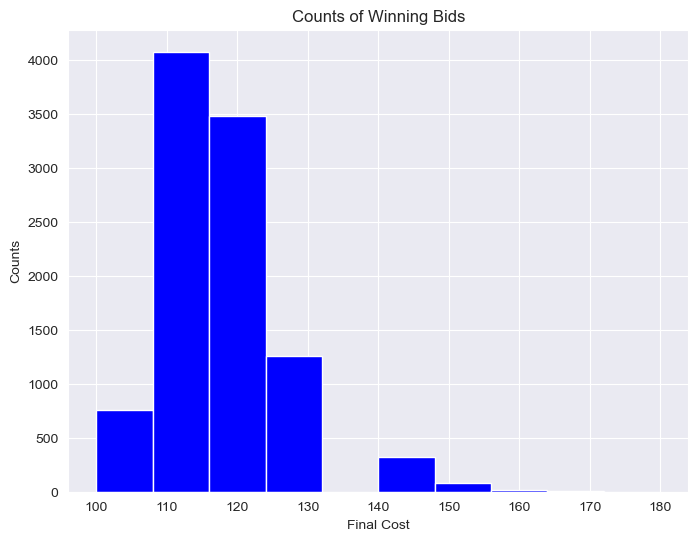

In [75]:
import random
from dataclasses import dataclass
import matplotlib.pyplot as plt
from scipy.ndimage import histogram

from seaborn import barplot
from statsmodels.stats.rates import nonequivalence_poisson_2indep
from sympy.physics.units import current

from monopoly_ml.property_init import get_properties


@dataclass
class Street:
    # This is used for standard properties
    name: str
    position: int
    cost_to_buy: int
    color_group: str
    mortgage_status: False
    owner: None
    rent: int
    house_cost: int
    hotel_cost: int
    one_house: int
    two_house: int
    three_house: int
    four_house: int
    hotel: int

    def __post_init__(self):
        self.house_status = 0
        self.hotel_status = 0
        self.mortgage = 0.5 * self.cost_to_buy
        self.unmortgage = self.mortgage + (0.1 * self.mortgage)

oriental_avenue = Street(
                        name = 'baltic avenue',
                        position = 6,
                        cost_to_buy = 100,
                        color_group = 'light blue',
                        mortgage_status = False,
                        owner = None,
                        rent = 6,
                        house_cost = 50,
                        hotel_cost = 50,
                        one_house = 20,
                        two_house = 60,
                        three_house = 180,
                        four_house = 320,
                        hotel = 450)

class Player:
    def __init__(self, name):
        self._name = name
        self._cash: int = 2000
        self._dict_owned_colors = {'brown': False, 'light_blue': False, 'purple': False, 'orange': False,
                                   'red'  : False, 'yellow': False, 'green': False, 'blue': False}
        self._list_owned_properties = []

def auction_property(property, players):
    """
    This function is logic for auctioning properties. All players are allowed to bid.
    If a player owns properties in the group it is very likely they will purchase the property.
    The auction ends when a player has outbid everyone else and there is only one active bidder
    :param property: The property being auctioned
    :param players: all bidding players
    :return: cost of purchasing auctioned property and auction winner
    """

    current_price = property.cost_to_buy
    bid_increment = property.cost_to_buy * 0.1 # base bid increment

    def _probability_of_raise(player, current_price):
        """
        Helper function to assign raising probability for a property
        :param player:
        :param current_price:
        :return:
        """
        if type(property) == Street:
            if property.color_group in player._dict_owned_colors:
                p_int = 0.99 # if we have a color group highly likely to purchase
            else:
                p_int = 0.5 # if we don't less likely to purchase
                
        else:
            if property.type == 'utility' and len(player._list_owned_utilites) > 0:
                p_int = 0.95
            elif property.type == 'railroad' and len(player._list_owned_railroads) > 0:
                p_int = 0.95
            else:
                p_int = 0.5
                
        cash_ratio = current_price / player._cash
        p_bid = (p_int * max(0.2, 1 - cash_ratio))
        if p_bid < 0.2:
            p_bid = 0.2
        return p_bid

    active_bidders = players.copy()
    current_winner = None
    
    while len(active_bidders) > 1:
        remaining_bidders = []
        for bidder in active_bidders:
            p_bid = _probability_of_raise(bidder, current_price)
            # Random choice weighted by probability
            if random.random() < p_bid:
                # Calculate bid increase based on remaining cash
                max_increase = min(
                        bidder._cash - current_price,  # Can't bid more than cash
                        bid_increment * (1 + p_bid)  # Higher probability = more aggressive
                )
                if max_increase > 0:
                    remaining_bidders.append(bidder)
                    current_winner = bidder

        active_bidders = remaining_bidders
        if remaining_bidders:
            current_price += bid_increment
        if current_winner == None:
            return ("NoWinner", current_price)
    return (current_winner._name, current_price)




player1 = Player('shoe')
player2 = Player('thimble')
player3 = Player('ship')
player4 = Player('car')


## Testing different parameters
player1._dict_owned_colors['light_blue'] = True
player1._cash -= 750
player2._dict_owned_colors['light_blue'] = True
#player2._cash -= 1000
player3._cash += 10000
#player4._cash -= 1000
        

players = [player1, player2, player3, player4]



# Simulation of auction
winning_dict = {'shoe': [], 'thimble': [], 'ship': [], 'car': [], 'NoWinner': []}
for i in range(10000):
    current_win = auction_property(oriental_avenue, players)
    winning_dict[current_win[0]].append(current_win[1])

# Get the counts from your winning_dict
keys = list(winning_dict.keys())
values = [len(winning_dict[key]) for key in keys]
final_bids = []
for key, value in winning_dict.items():
    final_bids.extend(value)
print(final_bids)
plt.figure(figsize=(8, 6))
plt.hist(final_bids, color = 'blue')
plt.xlabel('Final Cost')
plt.ylabel('Counts')
plt.title('Counts of Winning Bids')
plt.show()
#Barplot for aution visualization
# plt.figure(figsize=(8, 6))
# plt.bar(keys, values, color='blue')
# plt.xlabel('Items')
# plt.ylabel('Counts')
# plt.title('Counts of Winning Items')
# plt.show()

In [ ]:
from monopoly_ml.property_init import get_properties

property_dict = get_properties()

def calculate_trade_probability(player, opposing_player, property_offered, property_dict, property_wanted = None, money_offered = 0):
    """
    This function calculates the probability of a trade being completed in monopoly
    :param player:
    :param opposing_player:
    :param property_offered:
    :param property_wanted:
    :param money_offered:
    :return:
    """
    # Constants for probability weights
    BASE_PROB = 0.3
    MONOPOLY_WEIGHT = 0.8
    MONEY_WEIGHT = 0.2


    def _get_property_ratio(player, property):
        """
        helper function to get property to monopoly ratio
        :param player: player of interest
        :param property: property of interest
        :return: ratio of properties to monopoly
        """
        property_color = property.color_group
        player_in_group = sum(1 for p in player._list_owned_streets
                              if p.color_group == property_color)
        total_in__group = sum(1 for p in property_dict.values()
                              if p.color_group == property_color)
        return player_in_group / total_in__group

    # Calculate base probability
    player_ratio = _get_property_ratio(player, property_offered.color_group)
    opponent_ratio = _get_property_ratio(opposing_player, property_offered.color_group)
    
    opponent_willingness = opponent_ratio - player_ratio
    player_desire = player_ratio - opponent_ratio

    # Initial trade probability
    p_trade = BASE_PROB * (1 - player_ratio) * opponent_ratio

    # Adjust for monopoly potential
    if property_wanted:
        monopoly_potential = (get_property_ratio(opposing_player,
                                                 property_wanted.color) == 1)
        if monopoly_potential:
            p_trade *= (1 + MONOPOLY_WEIGHT)

    # Adjust for money incentive
    if money_offered > 0:
        money_factor = min(money_offered / property_offered.price, 2)
        p_trade *= (1 + MONEY_WEIGHT * money_factor)

    return min(1.0, max(0.1, p_trade))


def execute_trade(player, opposing_player, property_offered,
                  property_wanted = None, money_offered = 0):
    """
    Execute the trade between players if probability threshold is met
    """
    p_trade = calculate_trade_probability(player, opposing_player,
                                          property_offered, property_wanted,
                                          money_offered)

    if random.random() < p_trade:
        # Execute property exchange
        player._list_owned_properties.remove(property_offered)
        opposing_player._list_owned_properties.append(property_offered)

        if property_wanted:
            opposing_player._list_owned_properties.remove(property_wanted)
            player._list_owned_properties.append(property_wanted)

        if money_offered > 0:
            player.money -= money_offered
            opposing_player.money += money_offered

        return True

    return False


player1 = Player('shoe')
player2 = Player('thimble')


## Testing different parameters
player1._list_owned_properties.append()
player2._cash -= 1000
        